In [1]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
root_path = "/storage/liuyi/00.SNP_project/code/gigascience_update"

In [3]:
sample_list = ['CRC-P19-T','CRC-P59-T_1','CRC-P59-T_2','CRC-P67-T','LC05-M_DU3','LC05-T_FD3','dcis1','dcis2','slide_DNA','slide_RNA']

In [4]:
plat_color = ['#FF8A7D','#FC8E82','#FA9185','#E47479','#E57579','#E57579'] + ['#F8C170','#FBB479']+ ['#71BE4B'] + ['#00A1DF']
plat = ['stereo-seq']*6 + ['visium'] *2 + ['slide']*2

# Fig1

In [5]:
sample = 'CRC-P59-T_1'
cell_counts = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure1/snv_cells/{sample}.cells.csv')
sample = 'dcis1'
cell_counts1 = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure1/snv_cells/{sample}.cells.csv')
sample = 'slide_RNA'
cell_counts2 = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure1/snv_cells/{sample}.cells.csv')
sample = 'slide_DNA'
cell_counts3 = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure1/snv_cells/{sample}.cells.csv')

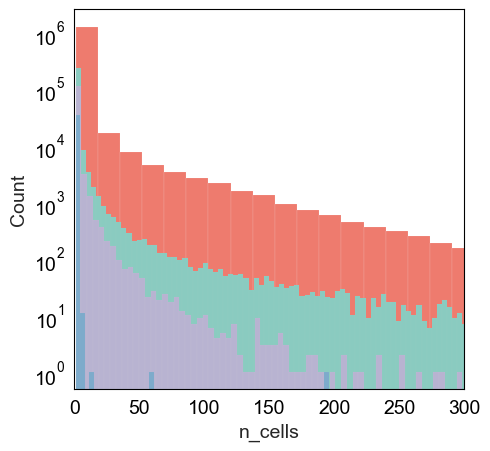

In [6]:
fig,ax = plt.subplots(figsize = (5,5))
bins = 300
palette= {'Slide-seq': "#B8B3D1", 'Stereo-seq': '#EE7B6E', 'Visium': '#7DABCB'}
hist = sns.histplot(cell_counts['n_cells'], bins=bins, kde=False,ax =ax,color = '#EE7B6E',edgecolor=None,rasterized =True,alpha = 1)
hist = sns.histplot(cell_counts1['n_cells'], bins=bins, kde=False,ax =ax,color = '#8ACBC0',edgecolor=None,rasterized =True,alpha = 1)
hist = sns.histplot(cell_counts2['n_cells'], bins=bins, kde=False,ax =ax,color = '#B8B3D1',edgecolor=None,rasterized =True,alpha = 1)
hist = sns.histplot(cell_counts3['n_cells'], bins=bins, kde=False,ax =ax,color = '#7DABCB',edgecolor=None,rasterized =True,alpha = 1)
ax.set_xlim(0,300)
ax.set_yscale('log')
ax.grid(False)
fig.show()

In [7]:
data = pd.read_csv(f'{root_path}/readstat_fromsamtools/stat.summary.csv',sep = '\t',header=None,names=['platform','sample','reads'])
count_dict = {}
for sample in sample_list:
    snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
    count_dict[sample] = snv.shape[1]
data['snvreads'] = data['sample'].map(count_dict)
unique_platforms = data['platform'].unique()
platform_to_color = {'Slide-RNA': "#00A1DF", 'Stereo-seq': '#E84B50', 'Visium': '#FAC319','Slide-DNA':'#83BC5B'}

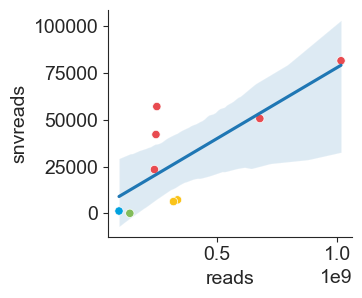

In [8]:
sns.set_style('ticks', {'axes.grid' : False})
g = sns.lmplot(data=data, x='reads', y='snvreads',height=3.2,aspect=1.2,legend=False,scatter = False)
for ax in g.axes.flatten():
    sns.scatterplot(data = data,x='reads', y='snvreads',hue = 'platform',ax = ax,palette=platform_to_color,legend=False)

In [9]:
stat_df = []
snv_set = {}
for sample in sample_list:
    if sample !='slide_DNA':
        snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
        stat = pd.DataFrame({sample:snv.var['Func_L0'].value_counts().loc[['UTR','Exonic','Intronic', 'Intergenic']].values})
        stat_df.append(stat)
        if sample.startswith('CRC'):
            snv_set[sample] = set(snv.var_names.tolist())
        if sample.startswith('LC'):
            snv_set[sample] = set(('chr'+ snv.var_names).tolist())
component_stat_df = pd.concat(stat_df,axis = 1).T
component_stat_df.columns = ['UTR','Exonic','Intronic', 'Intergenic']
component_stat_df = component_stat_df[::-1]
total = component_stat_df.sum(axis=1)
proportions = component_stat_df.divide(total, axis=0)

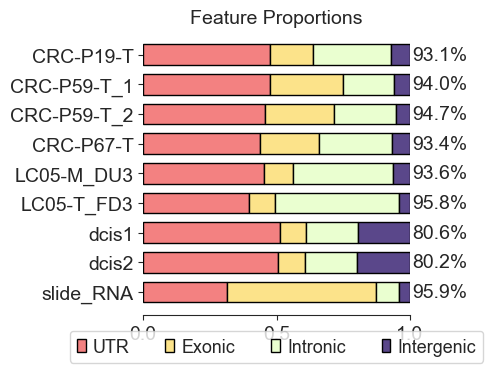

In [10]:
palette = ['#F38181','#FCE38A','#EAFFD0','#5A478A']
fig, ax = plt.subplots(figsize=(5, 4))
cumulative = np.cumsum(proportions.values, axis=1)
handles = []
for i, col in enumerate(proportions.columns):
    starts = cumulative[:, i-1] if i > 0 else np.zeros(proportions.shape[0])
    p = ax.barh(proportions.index, proportions[col], left=starts, height=0.7, color=palette[i], edgecolor='black')
    handles.append(p)
for i in range(proportions.shape[0]):
    ax.text(1.01, i, f"{(proportions.iloc[i, 0] + proportions.iloc[i, 1] + proportions.iloc[i, 2])*100:.1f}%", va='center')

ax.set_xlabel("")
ax.set_title("Feature Proportions")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(handles, proportions.columns, bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=len(proportions.columns))
plt.grid(False)
plt.gca().margins(x=0)
plt.tight_layout()
plt.show()

In [11]:
proportions['Percentage'] = proportions['Exonic'] + proportions['Intronic'] + proportions['UTR']
proportions['Percentage'] = proportions['Percentage'] * 100
proportions['platform'] = ['Slide-RNA']*1 + ['Visium']*2 + ['Stereo-seq']*6

/tmp/ipykernel_197253/2923693819.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cat = sns.catplot(data = proportions,x = 'platform',y = 'Percentage',capsize = .1,errorbar = 'se',kind='bar',aspect = 1 ,palette=platform_to_color,edgecolor = 'black',order = ['Stereo-seq','Visium','Slide-RNA'])


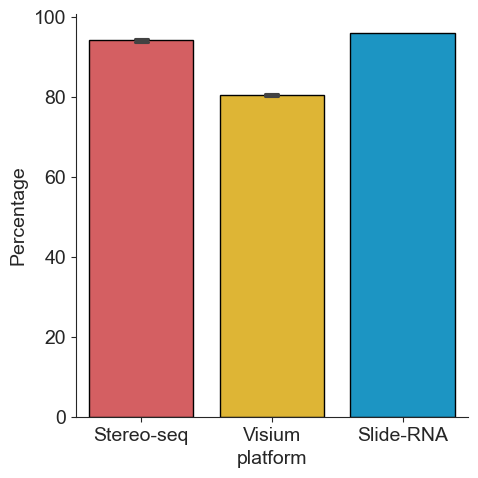

In [12]:
cat = sns.catplot(data = proportions,x = 'platform',y = 'Percentage',capsize = .1,errorbar = 'se',kind='bar',aspect = 1 ,palette=platform_to_color,edgecolor = 'black',order = ['Stereo-seq','Visium','Slide-RNA'])

In [13]:
from upsetplot import from_contents
from upsetplot import UpSet

In [14]:
fromupset = from_contents(snv_set)

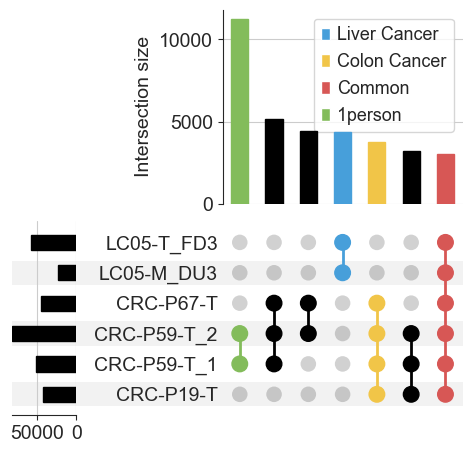

In [15]:
upset = UpSet(fromupset,sort_by = 'cardinality',sort_categories_by = 'input',min_degree = 2 ,subset_size="count",min_subset_size = 2500)
upset.style_subsets(present=["LC05-T_FD3", "LC05-M_DU3"],absent=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T'], facecolor="#479FDA", label="Liver Cancer")
upset.style_subsets(present=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T'],absent = ["LC05-T_FD3", "LC05-M_DU3"], facecolor="#F1C548", label="Colon Cancer")
upset.style_subsets(present=["CRC-P67-T", "CRC-P59-T_2","CRC-P59-T_1",'CRC-P19-T',"LC05-T_FD3", "LC05-M_DU3"], facecolor="#D75755", label="Common")
upset.style_subsets(present= ["CRC-P59-T_2","CRC-P59-T_1",],absent = ['CRC-P19-T',"LC05-T_FD3", "LC05-M_DU3","LC05-T_FD3", "LC05-M_DU3","CRC-P67-T"], facecolor="#83BC5B", label="1person")
upset.plot()
plt.show()

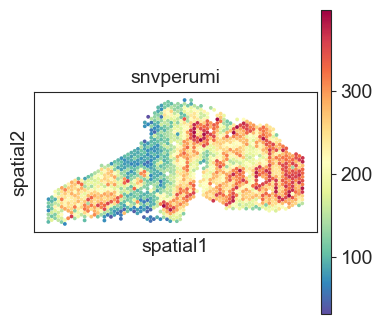

In [16]:
sample = 'dcis1'
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
sc.pl.spatial(snv,color = 'snvperumi',spot_size = 60,cmap = 'Spectral_r')

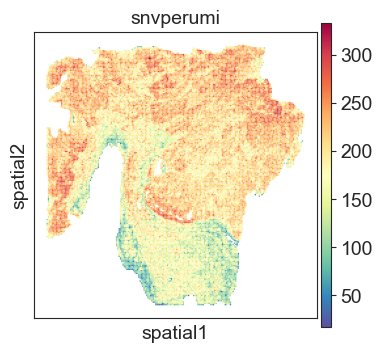

In [17]:
sample = 'CRC-P59-T_2'
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
sc.pl.spatial(snv,color = 'snvperumi',spot_size = 110,cmap = 'Spectral_r')

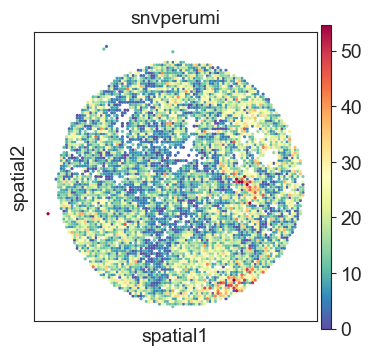

In [18]:
sample = 'slide_RNA'
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
sc.pl.spatial(snv,color = 'snvperumi',spot_size = 60,cmap = 'Spectral_r',vmax = 'p99.9')